(small-samples-notebook)=
# Modellizzazione SEM in Piccoli Campioni

Questo capitolo si focalizza sui modelli SEM in contesti dove i campioni sono di piccole dimensioni e riassume la presentazione di {cite:t}`rosseel2020small` su questo tema. Gli esempi numerici sono tratti da {cite:t}`kline2023principles`.

È noto che la maggior parte dei metodi di stima e inferenza in SEM sono basati su presupposti asintotici, cioè assumono l'esistenza di campioni casuali di grandi dimensioni. Tuttavia, in campioni più piccoli, come quelli con N < 200, emergono problematiche specifiche: i metodi iterativi possono non raggiungere la convergenza, possono verificarsi soluzioni non valide a causa dei cosiddetti casi di Heywood o altri risultati anomali difficili da interpretare, e le stime dei parametri possono risultare fortemente distorte.

Primo, i modelli a equazioni strutturali possono diventare molto grandi, coinvolgendo molte variabili (osservate e latenti). Di conseguenza, è necessario stimare molti parametri e una quantità ragionevole di dati è necessaria per ottenere stime di buona qualità per questi parametri. Secondo, il meccanismo statistico dietro la SEM tradizionale si basa sulla teoria dei grandi campioni, il che implica che una buona performance (sia nella stima puntuale dei parametri che nell'inferenza) è garantita solo quando la dimensione del campione è sufficientemente grande. Terzo, alcuni studi di simulazione nella letteratura SEM hanno suggerito che sono necessarie dimensioni di campione enormi per ottenere risultati affidabili. Anche se questi risultati erano rilevanti solo per impostazioni specifiche, questi studi hanno alimentato la convinzione ormai convenzionale che la SEM possa essere utilizzata solo se la dimensione del campione è ragionevolmente grande (ad esempio, n > 500) o addirittura molto grande (n > 2000).

Tuttavia, per molte ragioni, le piccole dimensioni del campione sono semplicemente una realtà. Quando ciò accade, molti ricercatori applicati esitano ad usare la SEM e invece impiegano procedure subottimali, come l'analisi di regressione o l'analisi di percorso basate su punteggi sommati. 
Però è importante riconoscere che il bias legato alla dimensione ridotta del campione può essere ancora più pronunciato in tecniche come la regressione multipla o l'analisi di percorso con variabili manifeste, specialmente quando non si tiene conto dell'errore di misurazione. Forse una strategia migliore sarebbe mantenere lo spirito della SEM ma cercare anche soluzioni per affrontare il problema delle piccole dimensioni del campione. 

Questo capitolo si propone di esplorare diverse strategie per superare le sfide poste dall'uso delle tecniche SEM in campioni di piccole dimensioni. Il capitolo è organizzato in tre sezioni: Prima, verranno presentate alcune questioni che possono sorgere con le piccole dimensioni del campione nella SEM. Successivamente, verranno presentati quattro approcci di stima alternativi che possono essere utilizzati (invece della SEM tradizionale) quando la dimensione del campione è piccola. Infine, verranno descritte alcune possibili correzioni per piccoli campioni per le statistiche di test e gli errori standard. L'efficacia di alcune di queste tecniche sarà illustrata attraverso l'analisi di un modello di fattore comune in un campione di piccole dimensioni.

In [1]:
source("../_common.R")
suppressPackageStartupMessages({
    library("semTools")
    library("lme4")
    library("here")
    library("MIIVsem")
})
set.seed(42)

## Problemi con le Piccole Dimensioni del Campione nella SEM

Consideriamo un modello SEM con almeno 4 indicatori continui per ciascuna variabile latente. Se tutte le variabili osservate sono continue, lo stimatore di default nella maggior parte (se non in tutti) dei pacchetti software SEM è il metodo della massima verosimiglianza. Generalmente, lo stimatore della massima verosimiglianza è una buona scelta perché presenta molte proprietà statistiche desiderabili. Inoltre, l'approccio della massima verosimiglianza può essere adattato per gestire dati mancanti (sotto l'assunzione che i dati siano mancanti casualmente) e sono stati sviluppati errori standard e statistiche di test "robusti" per trattare dati non normali e modelli mal specificati.

Tuttavia, se la dimensione del campione è relativamente piccola (ad esempio, n < 200), possono sorgere diversi problemi. Innanzitutto, il modello potrebbe non convergere, il che significa che l'ottimizzatore (l'algoritmo che cerca di trovare i valori dei parametri del modello che massimizzano la verosimiglianza dei dati) non è riuscito a trovare una soluzione che soddisfi uno o più criteri di convergenza. In rare occasioni, l'ottimizzatore potrebbe semplicemente sbagliare. In questo caso, modificare i criteri di convergenza, passare a un altro algoritmo di ottimizzazione o fornire valori iniziali migliori potrebbe risolvere il problema. Ma se la dimensione del campione è piccola, potrebbe benissimo essere che il set di dati non contenga informazioni sufficienti per trovare una soluzione unica per il modello.

Un secondo problema potrebbe essere che il modello ottenga la convergenza ma produca una soluzione non ammissibile. Ciò significa che alcuni parametri assumono valori inamissibili. L'esempio più comune è una varianza negativa. Un altro esempio è un valore di correlazione che supera 1 (in valore assoluto). È importante rendersi conto che alcuni approcci di stima (sia frequentisti che bayesiani) potrebbero, per progettazione, non produrre mai soluzioni fuori gamma. Sebbene ciò possa sembrare una caratteristica desiderabile, maschera potenziali problemi con il modello o i dati. È importante che gli utenti notino varianze negative (o altri parametri fuori gamma). Le varianze negative sono spesso innocue, ma possono essere un sintomo di una cattiva specificazione strutturale. 

Un terzo problema riguarda il fatto che la massima verosimiglianza è una tecnica per grandi campioni. Questo implica che lavorare con piccole dimensioni del campione può portare a stime puntuali distorte, errori standard troppo piccoli, intervalli di confidenza non sufficientemente ampi e p-valori per test di ipotesi non affidabili.

## Soluzioni Possibili per la Stima dei Parametri

In questa sezione, descrivo brevemente quattro approcci alternativi per stimare i parametri in un contesto SEM con dimensioni di campione piccole. Mi limito ai metodi frequentisti e alle soluzioni disponibili in software gratuiti e open-source.

### Stima di Verosimiglianza Penalizzata
I metodi di stima di verosimiglianza penalizzata (o metodi di regolarizzazione) sono stati sviluppati nella letteratura del machine learning statistico e sono particolarmente utili quando la dimensione del campione è piccola rispetto al numero di variabili nel modello. Questi metodi sono simili ai metodi di verosimiglianza ordinari (come la massima verosimiglianza) ma includono un termine di penalità aggiuntivo per controllare la complessità del modello. Il termine di penalità può essere formulato per incorporare conoscenze pregresse sui parametri o per scoraggiare valori dei parametri meno realistici (ad esempio, lontani da zero). Due termini di penalità popolari sono la penalità ridge e la penalità lasso (least absolute shrinkage and selection operator).

Per illustrare come funziona questa penalizzazione, immaginate un modello di regressione univariata con un gran numero di predittori. Senza penalizzazione, tutti i coefficienti di regressione sono calcolati nel modo usuale. Tuttavia, il termine di penalità ridge ridurrà tutti i coefficienti verso zero, mentre la penalità lasso ridurrà ulteriormente i piccoli coefficienti fino a zero. In quest'ultimo approccio, sopravvivono solo i predittori "forti" (per i quali c'è un forte supporto nei dati), mentre i predittori "deboli" che possono essere difficilmente distinti dal rumore vengono eliminati. In generale, l'aggiunta di termini di penalità porta a modelli meno complessi, il che è particolarmente vantaggioso se la dimensione del campione è piccola. 

Sebbene queste approcci di penalizzazione siano esistiti per alcuni decenni, sono stati applicati solo di recente alla SEM. Due esempi nel software `R` sono il pacchetto `regsem` (Jacobucci, Grimm, Brandmaier, Serang e Kievit, 2018) e il pacchetto `lslx` (Huang e Hu, 2018).

Uno svantaggio di questi metodi di penalizzazione è che l'utente deve indicare quali parametri richiedono la penalizzazione e in che misura. In un'analisi esplorativa, può essere utile e persino vantaggioso penalizzare i parametri verso zero se nel dati non si trova un forte supporto per essi. Tuttavia, la SEM è di solito un approccio confermativo, e l'utente deve assicurarsi che tutti i parametri inizialmente postulati nel modello non vengano rimossi dalla penalizzazione.

### Model-implied instrumental variables

Bollen (1996) ha proposto un approccio alternativo di stima per i modelli SEM basato sull'utilizzo di variabili strumentali implicite nel modello in combinazione con il metodo dei minimi quadrati a due stadi (MIIV-2SLS). In questo approccio, il modello viene tradotto in un insieme di equazioni (di regressione). Successivamente, ogni variabile latente in queste equazioni viene sostituita con il suo indicatore principale (solitamente il primo indicatore, dove il carico fattoriale è fissato a uno e l'intercetta a zero) meno il suo termine di errore residuo. Le equazioni risultanti non contengono più variabili latenti ma hanno una struttura dell'errore più complessa. È importante notare che la stima dei minimi quadrati ordinari non è più adatta per risolvere queste equazioni poiché alcuni predittori sono ora correlati con il termine di errore nell'equazione. Qui entrano in gioco le variabili strumentali (anche chiamate strumenti). Per ogni equazione, è necessario trovare un insieme di variabili strumentali. Una variabile strumentale deve essere non correlata con il termine di errore dell'equazione ma fortemente correlata con il predittore problematico. Di solito, le variabili strumentali sono ricercate al di fuori del modello, ma nell'approccio di Bollen, le variabili strumentali sono selezionate tra le variabili osservate che fanno parte del modello. Sono stati sviluppati diversi procedimenti automatizzati per trovare queste variabili strumentali all'interno del modello. Una volta selezionati gli strumenti, è necessaria una procedura di stima per stimare tutti i coefficienti delle equazioni, come il metodo dei minimi quadrati a due stadi (2SLS).

Una motivazione principale per MIIV-2SLS è che è robusto: non si basa sulla normalità ed è meno probabile che diffonda il bias (che può derivare da errate specificazioni strutturali) in una parte del modello ad altre parti del modello. Un'altra caratteristica attraente di MIIV-2SLS è che non è iterativo. Ciò significa che non possono esserci problemi di convergenza e MIIV-2SLS può fornire una soluzione ragionevole per modelli in cui il massimo verosimigliante fallisce nella convergenza.

Sono necessarie ulteriori ricerche per valutare le prestazioni di questo stimatore in contesti in cui la dimensione del campione è (molto) piccola. L'approccio MIIV-2SLS è disponibile nel pacchetto `R` `MIIVsem` (Fisher, Bollen, Gates, & Rönkkö, 2017).

### Stima a Due Fasi

Nel metodo di stima a due fasi, si effettua una distinzione tra la parte di misurazione e la parte strutturale (di regressione) del modello, e la stima avviene in due passaggi distinti. Nel primo passo, vengono adattati uno per uno tutti i modelli di misurazione. Nel secondo passo, viene adattato il modello completo, inclusa la parte strutturale, ma i parametri dei modelli di misurazione vengono mantenuti fissi ai valori trovati nel primo passo. La principale motivazione per l'approccio a due fasi è quella di separare il modello (o i modelli) di misurazione dalla parte strutturale durante la stima in modo che non possano influenzarsi reciprocamente. Nel tradizionale framework della massima verosimiglianza, invece, tutti i parametri vengono adattati simultaneamente. Di conseguenza, errori nella specificazione del modello strutturale possono influenzare i pesi fattoriali stimati di uno o più modelli di misurazione, e ciò può causare problemi di interpretazione per le variabili latenti.

L'approccio a due fasi è stato recentemente implementato nel pacchetto `R` `lavaan` (Rosseel, 2012). 

### Regressione del Punteggio dei Fattori

L'idea fondamentale della regressione del punteggio dei fattori è quella di sostituire tutte le variabili latenti con i loro punteggi. Questo processo è simile al metodo in due fasi, dove ciascun modello di misurazione viene adattato individualmente. Successivamente, si calcolano i punteggi dei fattori per tutte le variabili latenti nel modo consueto. Una volta che le variabili latenti sono sostituite dai loro punteggi, tutte le variabili diventano osservabili. In un passaggio finale, si stima la parte strutturale del modello. Questa stima può consistere in un'analisi di regressione o in un'analisi dei percorsi. Il termine “regressione del punteggio dei fattori” si riferisce a entrambi gli scenari.

Se usata in modo ingenuo, questa regressione potrebbe portare a un notevole bias nelle stime dei parametri della parte strutturale, anche con campioni di grandi dimensioni. Questo si verifica perché i punteggi dei fattori vengono trattati come se fossero osservati senza errore di misurazione. Esistono però diversi metodi per correggere questo bias. Ad esempio, il metodo di Croon (2002) procede come segue: prima, si calcola la matrice di varianza-covarianza dei punteggi dei fattori. Poi, sulla base delle informazioni dei modelli di misurazione, gli elementi di questa matrice vengono corretti per approssimare le varianze e covarianze implicite dal modello delle variabili latenti. Questa matrice di varianza-covarianza corretta diventa poi l'input per un'analisi di regressione o dei percorsi regolare.

Simile al metodo in due fasi, la regressione del punteggio dei fattori (combinata con la correzione di Croon) può essere un'alternativa utile per modelli piuttosto grandi in combinazione con una dimensione campionaria relativamente piccola. Inoltre, è possibile adattare i modelli di misurazione utilizzando un stimatore non iterativo, evitando problemi di convergenza. Tuttavia, la correzione di Croon può produrre una matrice di varianza-covarianza (per le variabili appartenenti alla parte strutturale) che non è definita positiva, specialmente se l'errore di misurazione è sostanziale. Pertanto, la correzione di Croon non è esente da problemi di stima. In questo caso, l'unica soluzione potrebbe essere quella di creare un punteggio somma per ogni variabile latente e stimare un modello in cui ogni variabile latente ha un unico indicatore (il punteggio somma) con la sua affidabilità fissata a un valore realistico fornito dall'utente.

### Discussione

Tutti i metodi descritti in questa sezione hanno vantaggi e svantaggi. L'approccio della verosimiglianza penalizzata è forse l'unico metodo specificamente progettato per gestire campioni (molto) piccoli. Gli altri tre metodi utilizzano un approccio di "divide et impera"; scompongono il modello completo in parti più piccole e stimano i parametri di ciascuna parte in successione. Oltre a ridurre la complessità e a essere meno vulnerabili a problemi di convergenza, gli ultimi tre metodi hanno il vantaggio di essere efficaci nel localizzare le parti problematiche all'interno di un modello ampio.

## Inferenze per Modelli SEM in Piccoli Campioni

Molti autori hanno documentato che quando la dimensione del campione è piccola, il test del chi-quadrato porta ad un inflezione degli errori di Tipo I anche nelle circostanze ideali (cioè, modello correttamente specificato, dati normali). Allo stesso modo, gli errori standard sono spesso attenuati (troppo piccoli) e gli intervalli di confidenza non sono sufficientemente ampi. 

Nelle due sottosezioni successive, {cite:t}`rosseel2020small` discute brevemente alcuni tentativi per affrontare questi problemi di inferenza su campioni piccoli nella modellizzazione SEM. 

### Migliorare la statistica test del chi-quadrato

Sono state suggerite diverse correzioni per migliorare le prestazioni della statistica del test del chi-quadrato, come la correzione di Bartlett. I risultati di studi di simulazione su questo tema, però, non sono coerenti e, secondo {cite:t}`rosseel2020small`, per valutare i modelli quando la dimensione del campione è piccola, potrebbe essere opportuno abbandonare del tutto il test del chi-quadrato e esplorare approcci alternativi. 

Un approccio è quello di considerare gli intervalli di confidenza e i test di aderenza basati sull'indice SRMR (standardized root mean square residuals; Maydeu-Olivares, Shi, & Rosseel, 2018). Questi test sembrano funzionare bene anche quando n = 100 (la dimensione del campione più piccola considerata in Maydeu-Olivares et al., 2018) e il modello non è troppo grande. Questi test sono stati implementati come parte della funzione `lavResiduals()` del pacchetto `lavaan`.

### Una migliore stima degli Errori Standard e degli Intervalli di Confidenza

In generale, è ben noto che se si utilizza la teoria dei grandi campioni per costruire espressioni analitiche al fine di calcolare gli errori standard, questi possono avere prestazioni scadenti in campioni di piccole dimensioni.

Quando le assunzioni alla base degli errori standard analitici non sono soddisfatte, spesso si suggerisce di utilizzare un approccio di resampling. Un metodo popolare è il bootstrap (Efron & Tibshirani, 1993): viene generato un campione bootstrap (o campione di replica) e si stima un nuovo set di parametri per questo campione bootstrap. Questo processo viene ripetuto un gran numero di volte (ad esempio, 1.000), e la deviazione standard di un parametro su tutti i campioni bootstrap replicati viene utilizzata come stima dell'errore standard per quel parametro. Purtroppo, nonostante molti altri vantaggi, sembra che il bootstrap non sia una soluzione affidabile quando la dimensione del campione è (molto) piccola (Yung & Bentler, 1996). 

In alternativa, sono state sviluppate correzioni per dimensioni di campione piccole sugli errori standard (robusti) e sono state recentemente adattate al contesto SEM. Tuttavia, questa tecnologia non è ancora disponibile nei software SEM.

### Strategie Alternative

Oltre ai metodi precedenti suggeriti da {cite:t}`rosseel2020small`, altre strategie possibili sono stati indicate da {cite:t}`kline2023principles`. 

1. **Selezione di Indicatori con Elevate Caratteristiche Psicometriche**: {cite:t}`kline2023principles` consiglia di utilizzare indicatori che mostrino eccellenti proprietà psicometriche, idealmente con carichi standardizzati superiori a .70 per gli indicatori continui. Questa pratica riduce il rischio di incorrere in casi di Heywood.

2. **Applicazione di Restrizioni di Uguaglianza sui Carichi Non Standardizzati**: Imponendo vincoli di uguaglianza sulle saturazioni degli indicatori relativi allo stesso fattore si possono evitare soluzioni inammissibili. Questo approccio è particolarmente valido quando gli indicatori sono sulla stessa scala. Un'alternativa valida consiste nel fissare le saturazioni degli indicatori dello stesso fattore a valori costanti non nulli, che riflettano le variazioni nelle loro deviazioni standard.

3. **SEM Basato su Compositi per Modelli Complessi in Campioni Piccoli**: L'utilizzo di metodi basati su compositi (cioè, combinazioni lineari di variabili osservate) può fornire risultati per modelli complessi che, con il SEM tradizionale, richiederebbero campioni molto più ampi. Tuttavia, è importante notare che anche i risultati del SEM basato su compositi possono essere distorti in campioni piccoli.

4. **Parceling**: Il "parceling" coinvolge la creazione di aggregati di due o più indicatori a livello di item attraverso la media dei singoli item, e quindi l'utilizzo di questi indicatori a livello di aggregato per rappresentare i costrutti latenti (Little, Cunningham, Shahar, & Widaman, 2002; Matsunaga, 2008). Sebbene il parceling possa ridurre la varianza dell'errore, è importante considerare le sue restrizioni e il fatto che i risultati possono variare notevolmente a seconda delle scelte fatte dal ricercatore durante l'analisi.

#### Parceling

Approfondiamo brevemente la strategia del parceling. Il parceling è una strategia che comporta la suddivisione di un set di item in gruppi più piccoli, o "parcel", per semplificare i modelli e migliorare la loro stima e adattamento. 

Un esempio, citato in {cite:t}`kline2023principles`, illustra come il parceling possa essere utilizzato in una CFA per ridurre il numero di indicatori e semplificare il modello. {cite:t}`kline2023principles` considera un questionario di 120 item diviso in tre gruppi distinti di 40 item ciascuno, ognuno mirato a misurare un dominio specifico di un costrutto. In un campione di 150 partecipanti, un'analisi fattoriale confermativa (CFA) con tre fattori e 40 indicatori per fattore, con 120 indicatori totali, può presentare sfide notevoli nella stima del modello a causa della ridotta dimensione del campione. Per affrontare questi problemi, il ricercatore può suddividere ogni gruppo di 40 item in 4 gruppi minori (o "parcel") di 10 item ciascuno, sommando i punteggi all'interno di ogni "parcel". Questi punteggi aggregati sostituiscono poi gli item singoli come indicatori in un modello CFA a 3 fattori che avrà quindi solo 12 indicatori in totale (4 indicatori parcellizzati per fattore). Se gli indicatori parcellizzati hanno una distribuzione normale, per la stima si può ricorrere al metodo dei minimi quadrati (ML); altrimenti, si può utilizzare un estimatore ML robusto.

Questo metodo è particolarmente utile in situazioni dove si hanno molti item e campioni di dimensioni ridotte, e offre diversi benefici, tra cui:

1. **Maggiore Affidabilità**: Il parceling può aumentare l'affidabilità di una scala psicometrica, poiché gli item aggregati tendono ad avere maggior coerenza interna rispetto agli item singoli.

2. **Rapporto Varianza Comune/Varianza Unica**: Utilizzando il parceling, si può ottenere un rapporto più favorevole tra la varianza comune (quella spiegata dai fattori comuni) e la varianza unica (quella non spiegata).

3. **Minore Probabilità di Violazioni Distribuzionali**: La pratica del parceling riduce la probabilità che le assunzioni distribuzionali siano violate, il che è importante per l'applicazione di certe tecniche statistiche.

Nonostante i suoi benefici, il parceling ha anche limitazioni. La metodologia utilizzata per formare i parcel può influenzare i risultati. Inoltre, il parceling non è consigliabile quando gli item all'interno di un parcel non sono unidimensionali, poiché ciò può distorcere i risultati. È fondamentale verificare l'unidimensionalità prima di procedere con il parceling.

In studi con campioni di piccole dimensioni, il parceling ha dimostrato diversi vantaggi, come mostrato nello studio di simulazione di Orçan e Yanyun (2016). Questi includono una riduzione della complessità del modello, tassi di errore di Tipo I più ragionevoli e tassi di errore di Tipo I più bassi quando si utilizza il metodo di stima della massima verosimiglianza con errori standard robusti (MLR) a livello di parcel.

In conclusione, il parceling è una tecnica utile che può migliorare l'affidabilità e la validità dei modelli psicometrici, specialmente in presenza di grandi set di item e campioni di piccole dimensioni. Tuttavia, è essenziale valutare attentamente la sua applicabilità e procedere con cautela, specialmente per quanto riguarda l'unidimensionalità dei parcel.

## SEM in un Piccolo Campione

{cite:t}`kline2023principles` discute uno studio in cui è stato applicato un modello CFA a due fattori ad un campione di 103 donne, le quali hanno compilato questionari su esperienze di origine familiare e adattamento coniugale {cite:p}`sabatelli2003family`. 

In [2]:
# input the correlations in lower diagnonal form
sabatelliLower.cor <- "
 1.000
  .740 1.000
  .265  .422 1.000
  .305  .401  .791 1.000
  .315  .351  .662  .587 1.000 "

# name the variables and convert to full correlation matrix
sabatelli.cor <- lavaan::getCov(sabatelliLower.cor, names = c(
    "problems", "intimacy", "father", "mother", "both"
    )
)

# add the standard deviations and convert to covariances
sabatelli.cov <- lavaan::cor2cov(sabatelli.cor, sds = c(
    32.936, 22.749, 13.390, 13.679, 14.382
    )
)

Il modello proposto dagli autori è specificato di seguito:

In [3]:
sabatelli_model <- "
    # common factors
    # loading for intimacy constrained to equal .691
    Marital =~ problems + intimacy
    FOE =~ father + mother + both
"

In riferimento al modello specificato sopra, la soluzione fornita da `lavaan` risulta inammissibile a causa di un caso di Heywood, evidenziato da una varianza d'errore negativa per la variabile "intimità".

In [4]:
original <- lavaan::sem(sabatelli_model,
    sample.cov = sabatelli.cov,
    sample.nobs = 103
)

Warning message in lav_object_post_check(object):
“lavaan WARNING: some estimated ov variances are negative”


In [5]:
lavaan::summary(original,
    fit.measures = TRUE, standardized = TRUE,
    rsquare = TRUE
) |> print()

lavaan 0.6.17 ended normally after 141 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        11

  Number of observations                           103

Model Test User Model:
                                                      
  Test statistic                                 4.688
  Degrees of freedom                                 4
  P-value (Chi-square)                           0.321

Model Test Baseline Model:

  Test statistic                               271.302
  Degrees of freedom                                10
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.997
  Tucker-Lewis Index (TLI)                       0.993

Loglikelihood and Information Criteria:

  Loglikelihood user model (H0)              -2087.964
  Loglikelihood unrestricted model (H1)      -2

Per ovviare ad un tale problema, in una nuova analisi del modello di adattamento coniugale è stato applicato un vincolo specifico ai carichi non standardizzati degli indicatori. A causa delle differenze sostanziali nelle metriche tra le due variabili, ovvero "intimacy" (con una deviazione standard di 22.749) e "problems" (con una deviazione standard di 32.936), sono state fissate le seguenti saturazioni fattoriali: il carico per la variabile "problemi" è stato fissato a 1, mentre il carico per la variabile "intimità" è stato fissato a 0.691. Questi valori sono stati calcolati in modo da riflettere proporzionalmente la differenza nelle deviazioni standard tra le due variabili.

In [6]:
# analysis with constrained loadings for indicators of marital adjustment
# model df = 5

# standard deviations for both indicators
# of the marital factor are listed next
# intimacy, sd = 22.749
# problems, sd = 32.936
# ratio = 22.749/32.936 = .691

# specify model with constrained loadings for problems, intimacy

proportional.model <- "
    # common factors
    # loading for intimacy constrained to equal .691
    Marital =~ 1*problems + .691*intimacy
    FOE =~ father + mother + both 
"

In [7]:
proportional <- lavaan::sem(proportional.model,
    sample.cov = sabatelli.cov,
    sample.nobs = 103
)

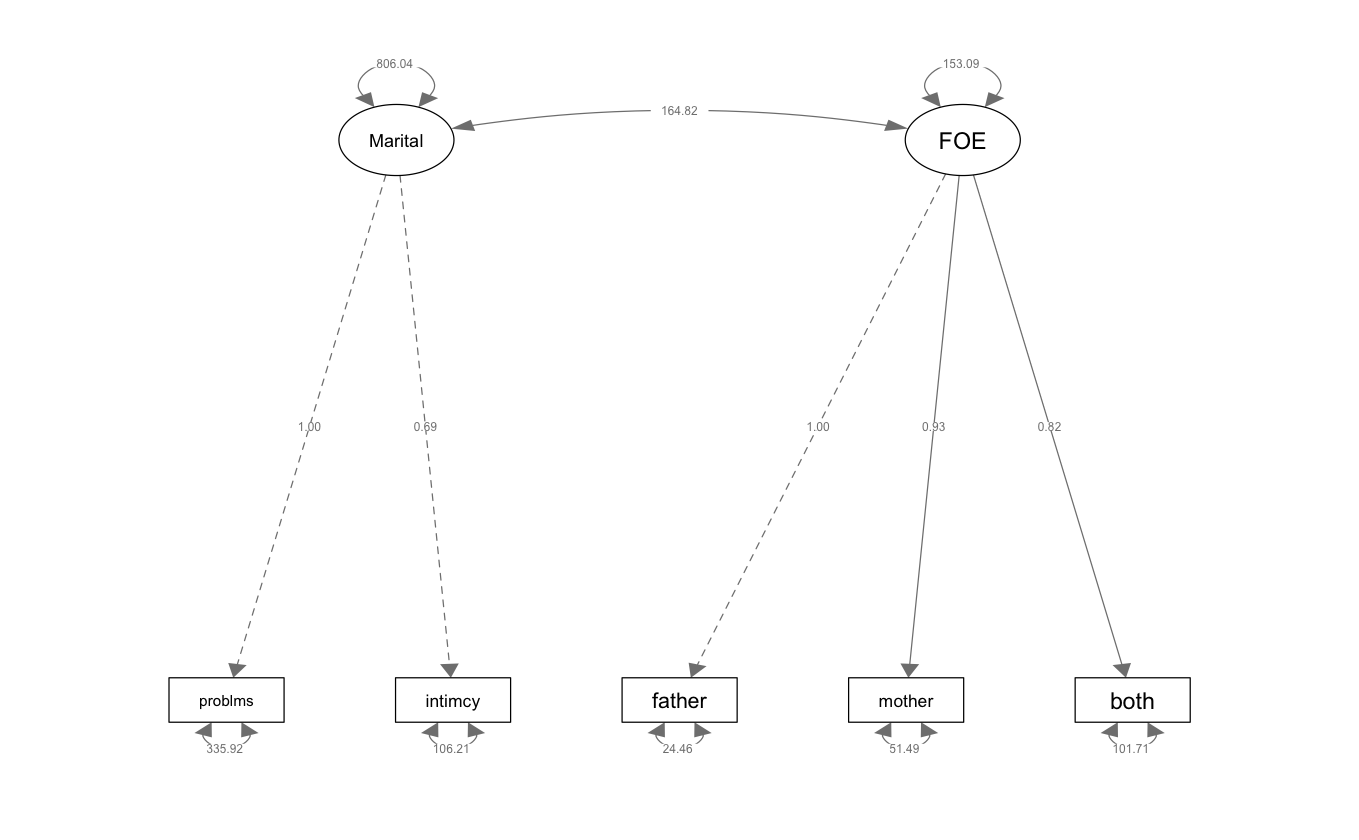

In [8]:
semPlot::semPaths(proportional,
    what = "col", whatLabels = "par", style = "mx", 
    layout = "tree2", nCharNodes = 7,
    shapeMan = "rectangle", sizeMan = 8, sizeMan2 = 5
)

In [9]:
lavaan::summary(proportional,
    fit.measures = TRUE, standardized = TRUE,
    rsquare = TRUE
) |> print()

lavaan 0.6.17 ended normally after 110 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        10

  Number of observations                           103

Model Test User Model:
                                                      
  Test statistic                                 8.449
  Degrees of freedom                                 5
  P-value (Chi-square)                           0.133

Model Test Baseline Model:

  Test statistic                               271.302
  Degrees of freedom                                10
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.987
  Tucker-Lewis Index (TLI)                       0.974

Loglikelihood and Information Criteria:

  Loglikelihood user model (H0)              -2089.845
  Loglikelihood unrestricted model (H1)      -2

In [10]:
fitMeasures(proportional, c("chisq", "df", "cfi", "tli", "rmsea", "srmr")) |>
    print()

chisq    df   cfi   tli rmsea  srmr 
8.449 5.000 0.987 0.974 0.082 0.045 


In [11]:
lavaan::parameterEstimates(proportional) |> print()

        lhs op      rhs     est      se      z pvalue ci.lower ci.upper
1   Marital =~ problems   1.000   0.000     NA     NA    1.000    1.000
2   Marital =~ intimacy   0.691   0.000     NA     NA    0.691    0.691
3       FOE =~   father   1.000   0.000     NA     NA    1.000    1.000
4       FOE =~   mother   0.935   0.091 10.279  0.000    0.757    1.113
5       FOE =~     both   0.821   0.100  8.235  0.000    0.625    1.016
6  problems ~~ problems 335.923  80.080  4.195  0.000  178.970  492.877
7  intimacy ~~ intimacy 106.214  34.373  3.090  0.002   38.843  173.584
8    father ~~   father  24.457  11.060  2.211  0.027    2.779   46.134
9    mother ~~   mother  51.489  11.730  4.389  0.000   28.498   74.481
10     both ~~     both 101.712  16.070  6.329  0.000   70.216  133.208
11  Marital ~~  Marital 806.040 132.946  6.063  0.000  545.471 1066.608
12      FOE ~~      FOE 153.095  26.669  5.741  0.000  100.825  205.365
13  Marital ~~      FOE 164.822  42.788  3.852  0.000   80.959  

In [12]:
lavaan::standardizedSolution(proportional) |> print()

        lhs op      rhs est.std    se      z pvalue ci.lower ci.upper
1   Marital =~ problems   0.840 0.036 23.439  0.000    0.770    0.910
2   Marital =~ intimacy   0.885 0.037 24.040  0.000    0.813    0.957
3       FOE =~   father   0.929 0.035 26.779  0.000    0.861    0.997
4       FOE =~   mother   0.850 0.040 21.126  0.000    0.771    0.929
5       FOE =~     both   0.710 0.055 12.800  0.000    0.601    0.818
6  problems ~~ problems   0.294 0.060  4.884  0.000    0.176    0.412
7  intimacy ~~ intimacy   0.216 0.065  3.317  0.001    0.088    0.344
8    father ~~   father   0.138 0.064  2.139  0.032    0.012    0.264
9    mother ~~   mother   0.278 0.068  4.065  0.000    0.144    0.412
10     both ~~     both   0.497 0.079  6.313  0.000    0.342    0.651
11  Marital ~~  Marital   1.000 0.000     NA     NA    1.000    1.000
12      FOE ~~      FOE   1.000 0.000     NA     NA    1.000    1.000
13  Marital ~~      FOE   0.469 0.091  5.177  0.000    0.292    0.647


Nonostante gli indici di bontà di adattamento siano eccellenti, la potenza di questa analisi statistica risulta estremamente limitata. Per valutare questa limitazione, è possibile utilizzare la funzione `semTools::findRMSEAsamplesize()`. Questa funzione calcola la dimensione del campione necessaria per rilevare una differenza significativa tra RMSEA_0 e RMSEA_A, considerando un modello con `df` gradi di libertà.

Per esempio, se desideriamo distinguere tra RMSEA_0=0.05 e RMSEA_A=0.10 utilizzando il modello attuale con 5 gradi di libertà, la funzione ci indica che sono necessarie 561 osservazioni per ottenere una potenza statistica di 0.8:

In [13]:
semTools::findRMSEAsamplesize(0.05, .10, 5, .80, .05, 1)

[1] 561

Per creare un grafico che rappresenti la potenza statistica per rilevare la differenza tra RMSEA_0=0.05 e RMSEA_A=0.10 (utilizzati qui come esempio) al variare della dimensione del campione, è possibile seguire la seguente procedura:

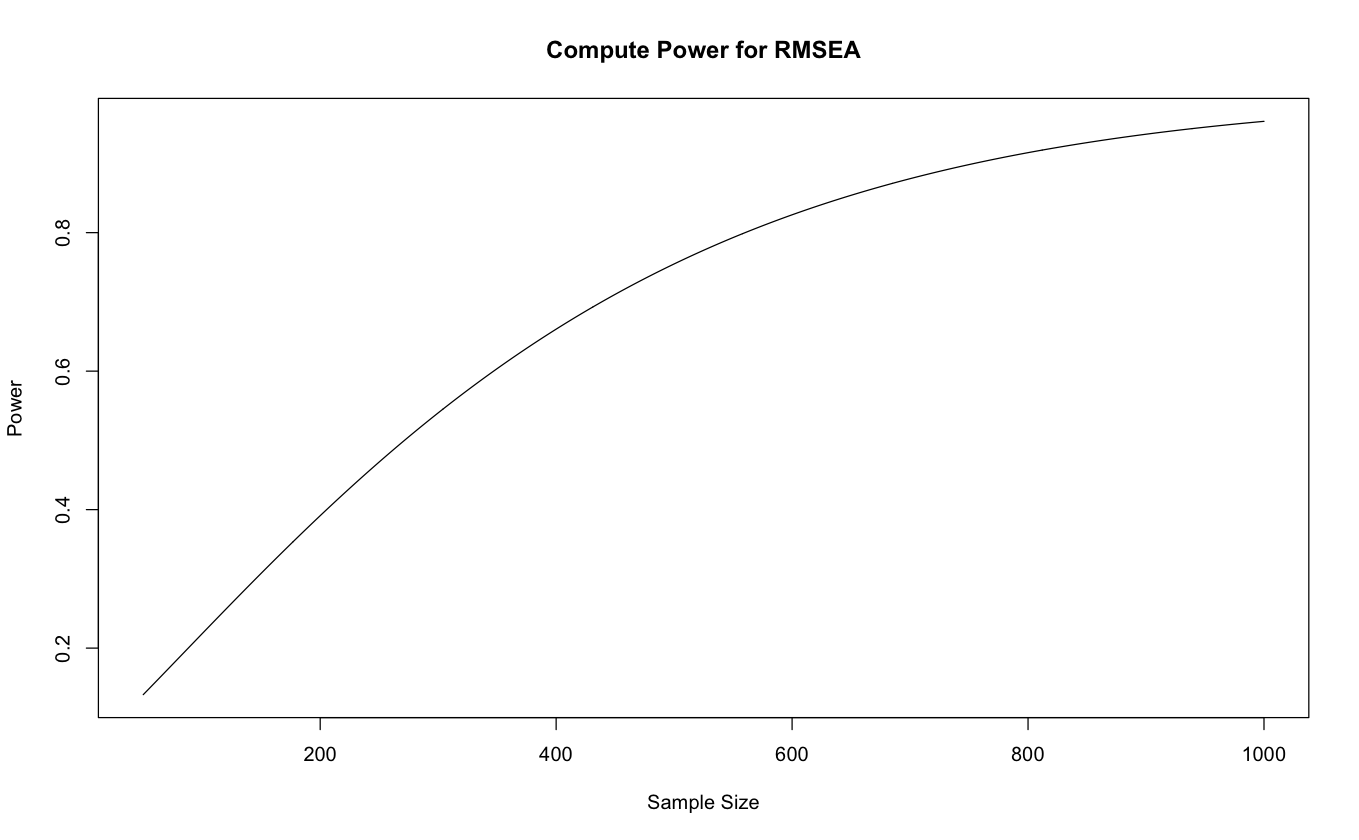

In [14]:
semTools::plotRMSEApower(rmsea0 = .05, rmseaA = .10, df = 5, 50, 1000)

Questa analisi di potenza indica che la dimensione del campione utilizzato ($n$ = 103) è del tutto inadeguata.

Per migliorare il nostro giudizio sull'adattamento del modello consideriamo l'analisi dei residui.

In [15]:
lavaan::residuals(proportional, type = "standardized.mplus") |> print()

$type
[1] "standardized.mplus"

$cov
         prblms intmcy father mother   both
problems     NA                            
intimacy     NA  0.918                     
father   -3.994  1.039  0.002              
mother   -0.871  1.049  0.328  0.000       
both      0.407  0.930  0.352 -2.776     NA



In [16]:
lavaan::lavResiduals(proportional, type = "cor.bollen", summary = TRUE) |> print()

$type
[1] "cor.bollen"

$cov
         prblms intmcy father mother   both
problems  0.000                            
intimacy -0.004  0.000                     
father   -0.101  0.036  0.000              
mother   -0.030  0.048  0.002  0.000       
both      0.035  0.056  0.003 -0.016  0.000

$cov.z
         prblms intmcy father mother   both
problems  0.000                            
intimacy -2.524  0.000                     
father   -2.386  1.245  0.000              
mother   -0.586  1.134  0.881  0.000       
both      0.523  0.936  0.507 -1.143  0.000

$summary
                           cov
crmr                     0.044
crmr.se                  0.015
crmr.exactfit.z          0.504
crmr.exactfit.pvalue     0.307
ucrmr                    0.023
ucrmr.se                 0.029
ucrmr.ci.lower          -0.024
ucrmr.cilupper           0.071
ucrmr.closefit.h0.value  0.050
ucrmr.closefit.z        -0.928
ucrmr.closefit.pvalue    0.823



Questi sono risultati relativamente scarsi per un modello così piccolo. Il computer non è stato in grado di calcolare tutti i residui standardizzati possibili, il che non è sorprendente in un campione così ridotto.

### Stimatore MIIV-2SLS

Una seconda analisi viene svolta usando lo stimatore MIIV-2SLS. Il pacchetto MIIVsem non calcola statistiche globali di adattamento. Invece, il pacchetto MIIVsem calcola il test di Sargan per ciascun indicatore previsto dal modello. Le statistiche del test di Sargan approssimano distribuzioni chi-quadro centrali con gradi di libertà che corrispondono al numero di item meno uno; quindi, df = 2. L'ipotesi nulla è che ciascun insieme di strumenti multipli sia incorrelato con il termine di errore per l'equazione. Il mancato rifiuto dell'ipotesi nulla per il test di Sargan suggerisce un'evidenza di buon adattamento del modello ai dati. 

In [17]:
MIIVsem::miivs(sabatelli_model)

Model Equation Information 

 LHS        RHS        MIIVs                     
 intimacy   problems   father, mother, both      
 mother     father     problems, intimacy, both  
 both       father     problems, intimacy, mother



In [18]:
sabatelli <- MIIVsem::miive(sabatelli_model,
    sample.cov = sabatelli.cov,
    sample.nobs = 103, var.cov = TRUE
)

lavaan::summary(sabatelli, rsquare = TRUE) |> print()

MIIVsem (0.5.8) results 

Number of observations                                                    103
Number of equations                                                         3
Estimator                                                           MIIV-2SLS
Standard Errors                                                      standard
Missing                                                              listwise


Parameter Estimates:


STRUCTURAL COEFFICIENTS:
                   Estimate  Std.Err  z-value  P(>|z|)   Sargan   df   P(Chi)
  FOE =~                                                                     
    father            1.000                                                  
    mother            0.899    0.089   10.149    0.000    1.763    2    0.414
    both              0.787    0.099    7.935    0.000    3.590    2    0.166
  Marital =~                                                                 
    problems          1.000                                       

Si noti che le stime standardizzate non sono calcolate nella versione del pacchetto MIIVsem utilizzata in questa analisi. I valori non standardizzati delle saturazioni fattoriali sono simili a quelli ottenuti in precedenza.

Il pacchetto `MIIVsem` non fornisce né le correlazioni previste dal modello per gli indicatori né i residui di correlazione. Per ottenere i residui di correlazione per l'estimatore 2SLS, è possibile utilizzare il pacchetto `lavaan` per specificare nuovamente il modello precedentemente adattato, ma con l'importante modifica di fissare tutti i parametri non standardizzati in modo che siano identici alle loro controparti 2SLS. Successivamente, è possibile adattare nuovamente il modello con questi parametri fissati alla matrice di covarianza. La matrice di correlazione prevista in questa analisi si basa sulle stime dei parametri 2SLS, consentendo così di ottenere i residui di correlazione desiderati.

In [19]:
sabatelliFixed.model <- "
    # common factors
    Marital =~ 1.0*problems + .805*intimacy
    FOE =~ 1.0*father + .899*mother + .787*both
    # factor variances, covariances
    FOE ~~ 158.501*FOE
    Marital ~~ 157.495*FOE
    Marital ~~ 702.393*Marital
    # indicator error variances
    father ~~ 20.856*father
    mother ~~ 54.195*mother
    both ~~ 103.301*both
    problems ~~ 422.427*problems
    intimacy ~~ 50.781*intimacy 
 "

In [20]:
sabatelliFixed <- lavaan::sem(sabatelliFixed.model,
    sample.cov = sabatelli.cov,
    sample.nobs = 103
)

In [21]:
# standardized parameter "estimates" listed
# next are fixed to nonzero constants, and
# standard errors are undefined
lavaan::parameterEstimates(sabatelliFixed)

lhs,op,rhs,est,se,z,pvalue,ci.lower,ci.upper
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Marital,=~,problems,1.000,0,NA,NA,1.000,1.000
Marital,=~,intimacy,0.805,0,NA,NA,0.805,0.805
FOE,=~,father,1.000,0,NA,NA,1.000,1.000
FOE,=~,mother,0.899,0,NA,NA,0.899,0.899
FOE,=~,both,0.787,0,NA,NA,0.787,0.787
FOE,~~,FOE,158.501,0,NA,NA,158.501,158.501
Marital,~~,FOE,157.495,0,NA,NA,157.495,157.495
Marital,~~,Marital,702.393,0,NA,NA,702.393,702.393
father,~~,father,20.856,0,NA,NA,20.856,20.856


In [22]:
lavaan::residuals(sabatelliFixed, type = "standardized.mplus") |> print()

$type
[1] "standardized.mplus"

$cov
         prblms intmcy father mother   both
problems -0.338                            
intimacy -0.180  0.092                     
father   -0.938  0.016 -0.073              
mother   -0.120  0.293  0.043  0.116       
both      0.491  0.412  0.067  0.100  0.118



In [23]:
lavaan::residuals(sabatelliFixed, type = "cor.bollen") |> print()

$type
[1] "cor.bollen"

$cov
         prblms intmcy father mother   both
problems  0.000                            
intimacy -0.010  0.000                     
father   -0.086  0.001  0.000              
mother   -0.008  0.026  0.003  0.000       
both      0.055  0.038  0.006  0.002  0.000



Si noti che nessuno dei residui di correlazione assoluti basati sui risultati 2SLS supera lo 0.10, compreso il residuo per la coppia di indicatori "problems" e "father". In termini di adattamento locale, dunque, in questo esempio i risultati dello stimatore 2SLS sono da preferire rispetto a quelli dello stimatore ML.

## Considerazioni Conclusive

In questo capitolo abbiamo discusso diversi problemi nel contesto della SEM quando le dimensioni del campione sono ridotte e vengono utilizzati metodi di stima standard (massima verosimiglianza), come la mancata convergenza, le soluzioni non ammissibili, il bias, le statistiche di test poco performanti e gli intervalli di confidenza e gli errori standard inaccurati. Come possibili soluzioni per ottenere stime puntuali migliori, {cite:t}`rosseel2020small` presenta quattro approcci alternativi alla stima: la stima della verosimiglianza penalizzata, le variabili strumentali derivanti dal modello, la stima a due fasi e la regressione dei punteggi fattoriali. Solo il primo metodo è stato specificamente progettato per gestire campioni ridotti. Gli altri approcci sono stati sviluppati con altre preoccupazioni in mente, ma potrebbero essere alternative valide per la stima quando le dimensioni del campione sono ridotte.

Per quanto riguarda l'inferenza, {cite:t}`rosseel2020small` discute vari tentativi per migliorare le prestazioni della statistica del chi-quadro per valutare l'adattamento globale in presenza di campioni ridotti. Per quanto riguarda gli errori standard, sottolinea che il bootstrapping potrebbe non essere la soluzione che stiamo cercando. Per ottenere errori standard (e intervalli di confidenza) migliori nel contesto di campioni ridotti, {cite:t}`rosseel2020small` ritiene che sia necessario aspettare fino a quando nuove tecnologie saranno disponibili. Altri suggerimenti sono stati forniti da {cite:t}`kline2023principles`. La tecnica del "parceling" è stata presentata in relazione alla discussione fornita da {cite:t}`rioux2020item`.